## install/update/import/clone

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00:00:0100:01


In [ ]:
!pip install GPUtil -q

  Preparing metadata (setup.py) ... done


In [ ]:
# Создаем папку для репозитория
!mkdir object_foto_dataset
%cd object_foto_dataset

# Инициализируем пустой репозиторий
!git init

# Добавляем удаленный репозиторий
!git remote add origin https://github.com/torpedonosec80/object_foto_dataset.git

# Включаем sparse checkout
!git config core.sparseCheckout true

# Указываем путь к нужной директории (models_selection/analitic)
!echo "boxes_dataset" >> .git/info/sparse-checkout

# Загружаем только указанную директорию
!git pull origin main  # или master, если используется другая ветка

%cd '/content'

Cloning into 'object_foto_dataset'...
remote: Enumerating objects: 23859, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 23859 (delta 11), reused 5 (delta 5), pack-reused 23841 (from 5)
Receiving objects: 100% (23859/23859), 403.11 MiB | 50.11 MiB/s, done.
Resolving deltas: 100% (15475/15475), done.
Updating files: 100% (6622/6622), done.


In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from torchmetrics.detection import MeanAveragePrecision
import gc
from copy import deepcopy
from datetime import datetime
from google.colab import drive
import shutil

import GPUtil

In [ ]:
print(GPUtil.showUtilization())

| ID | GPU | MEM |
------------------
|  0 |  0% | 48% |
|  1 |  0% |  0% |
None


## config

In [ ]:
# Конфигурация
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = {
    0: 'background',
    1: 'shta-9m',
    2: 'shta-ps',
    3: 'shta-7m',
    4: 'e2-6u',
    5: 'shta-9',
    6: 'shta-3',
    7: 'sv-5'
}
CLASS_NAME_TO_ID = {v: k for k, v in CLASSES.items()}
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 3  # Уменьшили batch size для Mask R-CNN
NUM_EPOCHS = 30
LEARNING_RATE = 0.005
PRINT_FREQ = 20

# Путь к данным
DATA_DIR = "/kaggle/working/object_foto_dataset/boxes_dataset"

## datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + '.xml')

        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        boxes = []
        labels = []

        # Парсинг XML
        tree = ET.parse(ann_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in CLASS_NAME_TO_ID:
                continue
            label = CLASS_NAME_TO_ID[class_name]

            # Получение bounding box
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Создание масок (прямоугольники)
        masks = []
        for box in boxes:
            mask = np.zeros((height, width), dtype=np.uint8)
            mask[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1
            masks.append(mask)

        # Конвертация в тензоры
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8) if masks else torch.zeros((0, height, width), dtype=torch.uint8)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'masks': masks,
            'labels': labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

## transforms

In [ ]:
# Трансформации
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Создание полного датасета
full_dataset = CustomDataset(DATA_DIR, DATA_DIR, transform)

# Разделение данных
indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.176, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Dataset sizes: Train=654, Val=140, Test=141


In [ ]:
# Функция для получения модели Mask R-CNN
def get_model(num_classes):
    # Загружаем предобученную модель Mask R-CNN
    weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)

    # Заменяем классификатор головы для детекции
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features,
        num_classes
    )

    # Заменяем mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        256,  # hidden_layer
        num_classes
    )

    model.to(DEVICE)
    return model

In [ ]:
model = get_model(NUM_CLASSES)

In [ ]:
def calculate_map(model, data_loader, device):
    model.eval()
    try:
        metric = MeanAveragePrecision(
            iou_thresholds=[0.5],  # Упростили до одного порога для экономии памяти
            class_metrics=False     # Отключили вычисление по классам
        )

        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                if batch is None:
                    continue

                images, targets = batch
                if not images or len(images) == 0:
                    continue

                images = [img.to(device) for img in images]
                outputs = model(images)

                preds = []
                for output in outputs:
                    # Фильтруем предсказания с низкой уверенностью
                    keep = output['scores'] > 0.05
                    filtered_output = {
                        'boxes': output['boxes'][keep].cpu(),
                        'scores': output['scores'][keep].cpu(),
                        'labels': output['labels'][keep].cpu()
                    }
                    preds.append(filtered_output)

                gt = []
                for target in targets:
                    gt.append({
                        'boxes': target['boxes'].cpu(),
                        'labels': target['labels'].cpu()
                    })

                metric.update(preds, gt)

                # Явная очистка памяти после каждого батча
                del images, outputs, preds, gt, filtered_output
                torch.cuda.empty_cache()
                if i % 10 == 0:
                    gc.collect()

        return metric.compute()

    except Exception as e:
        print(f"Error in mAP calculation: {e}")
        return {
            'map': torch.tensor(0.0),
            'map_50': torch.tensor(0.0),
            'map_75': torch.tensor(0.0)
        }

## обучение

In [ ]:
# Оптимизатор и планировщик
# Параметры оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9)

# Создаем директорию для сохранения моделей
os.makedirs('saved_models', exist_ok=True)

# Инициализация переменных для лучшей модели
best_map = 0.0
best_model_weights = None

# Списки для логирования
train_losses = []
val_maps = []

# Основной цикл обучения
for epoch in range(NUM_EPOCHS):
    # === Фаза обучения ===
    model.train()
    epoch_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(DEVICE) for img in images]
        # Для Mask R-CNN нужно переместить все элементы цели
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Прямой проход и вычисление потерь
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Обратное распространение
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        if i % PRINT_FREQ == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Batch: {i+1}, Loss: {losses.item():.4f}')

    # Средняя потеря за эпоху
    epoch_avg_loss = epoch_loss / len(train_loader)
    train_losses.append(epoch_avg_loss)
    print(f'Epoch {epoch+1} Train Loss: {epoch_avg_loss:.4f}')

    # === Фаза валидации ===
    val_metrics = calculate_map(model, val_loader, DEVICE)
    val_map = val_metrics['map'].item()
    val_maps.append(val_map)

    print(f'Epoch {epoch+1} Validation mAP: {val_map:.4f}')
    print(f'Validation metrics: mAP@50={val_metrics["map_50"].item():.4f}, mAP@75={val_metrics["map_75"].item():.4f}')

    # Обновление планировщика
    # scheduler.step(val_map)

    # Освобождаем память
    torch.cuda.empty_cache()
    gc.collect()

    # === Сохранение моделей ===
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'saved_models/checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_avg_loss,
            'val_map': val_map,
        }, checkpoint_path)
        print(f'Saved checkpoint: {checkpoint_path}')

    if val_map > best_map:
        best_map = val_map
        best_model_weights = deepcopy(model.state_dict())
        best_model_path = 'saved_models/best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_weights,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_avg_loss,
            'val_map': val_map,
        }, best_model_path)
        print(f'New best model saved with mAP {best_map:.4f} at {best_model_path}')

Epoch: 1/30, Batch: 1, Loss: 0.4788
Epoch: 1/30, Batch: 21, Loss: 0.3957
Epoch: 1/30, Batch: 41, Loss: 0.3419
Epoch: 1/30, Batch: 61, Loss: 0.3346
Epoch: 1/30, Batch: 81, Loss: 0.5279
Epoch: 1/30, Batch: 101, Loss: 0.3071
Epoch: 1/30, Batch: 121, Loss: 0.3367
Epoch: 1/30, Batch: 141, Loss: 0.3469
Epoch: 1/30, Batch: 161, Loss: 0.2675
Epoch: 1/30, Batch: 181, Loss: 0.3846
Epoch: 1/30, Batch: 201, Loss: 0.3607
Epoch 1 Train Loss: 0.3332
Epoch 1 Validation mAP: 0.7404
Validation metrics: mAP@50=0.7404, mAP@75=-1.0000
New best model saved with mAP 0.7404 at saved_models/best_model.pth
Epoch: 2/30, Batch: 1, Loss: 0.2518
Epoch: 2/30, Batch: 21, Loss: 0.2460
Epoch: 2/30, Batch: 41, Loss: 0.1513
Epoch: 2/30, Batch: 61, Loss: 0.2639
Epoch: 2/30, Batch: 81, Loss: 0.1637
Epoch: 2/30, Batch: 101, Loss: 0.1600
Epoch: 2/30, Batch: 121, Loss: 0.2873
Epoch: 2/30, Batch: 141, Loss: 0.2621
Epoch: 2/30, Batch: 161, Loss: 0.1264
Epoch: 2/30, Batch: 181, Loss: 0.1332
Epoch: 2/30, Batch: 201, Loss: 0.1463


## оценка тест

Training complete. Final model saved at saved_models/final_model.pth

=== Final Test Results ===
Test mAP: 0.9272
Test mAP@50: 0.9272
Test mAP@75: -1.0000


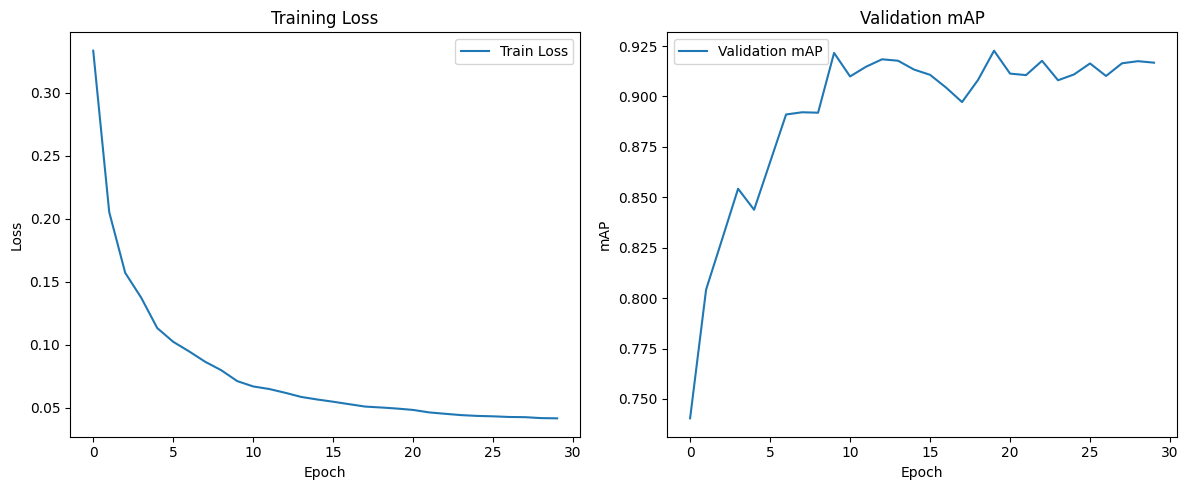

In [ ]:
# Сохраняем финальную модель
final_model_path = 'saved_models/final_model.pth'
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': epoch_avg_loss,
    'val_map': val_map,
}, final_model_path)
print(f'Training complete. Final model saved at {final_model_path}')

# Тестирование на тестовом наборе
test_metrics = calculate_map(model, test_loader, DEVICE)
test_map = test_metrics['map'].item()
print(f'\n=== Final Test Results ===')
print(f'Test mAP: {test_map:.4f}')
print(f'Test mAP@50: {test_metrics["map_50"].item():.4f}')
print(f'Test mAP@75: {test_metrics["map_75"].item():.4f}')

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_maps, label='Validation mAP')
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

обучение заняло около 5 часов!!!

## image detection

In [ ]:
# Функция для визуализации предсказаний с масками
def visualize_predictions(model, dataset, num_samples=5, threshold=0.3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 1, figsize=(12, 6*num_samples))

    for idx, ax in zip(indices, axs):
        # Получаем имя файла как третий элемент
        image, target = dataset[idx]

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])[0]

        img = image.cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        # Добавляем имя файла в заголовок
        ax.set_title(f"File: ", fontsize=12, pad=10)

        # Отрисовка предсказаний (боксы и маски)
        for score, box, label, mask in zip(
            prediction['scores'],
            prediction['boxes'],
            prediction['labels'],
            prediction['masks']
        ):
            if score > threshold:
                box = box.cpu().numpy()
                mask = mask[0].cpu().numpy()  # Берем первый канал маски

                # Рисуем маску
                colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
                colored_mask[mask > 0.5] = [1, 0, 0, 0.4]  # Красный с прозрачностью
                ax.imshow(colored_mask, alpha=0.3)

                # Рисуем bounding box
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                        linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Добавляем подпись
                label_name = CLASSES[label.item()]
                ax.text(box[0] + 2, box[1] + 10,
                        f'{label_name} {score:.4f}',
                        color='white', fontsize=10,
                        bbox=dict(facecolor='red', alpha=0.8))

        # Отрисовка истинных боксов (справа)
        for box, label in zip(target['boxes'], target['labels']):
            box = box.cpu().numpy()
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   linewidth=1, edgecolor='g', facecolor='none', linestyle=':')
            ax.add_patch(rect)
            ax.text(box[2] - 2, box[1] + 10,
                   f'TRUE: {CLASSES[label.item()]}',
                   color='green', fontsize=8,
                   bbox=dict(facecolor='white', alpha=0.7),
                   horizontalalignment='right')

    plt.tight_layout()
    plt.show()

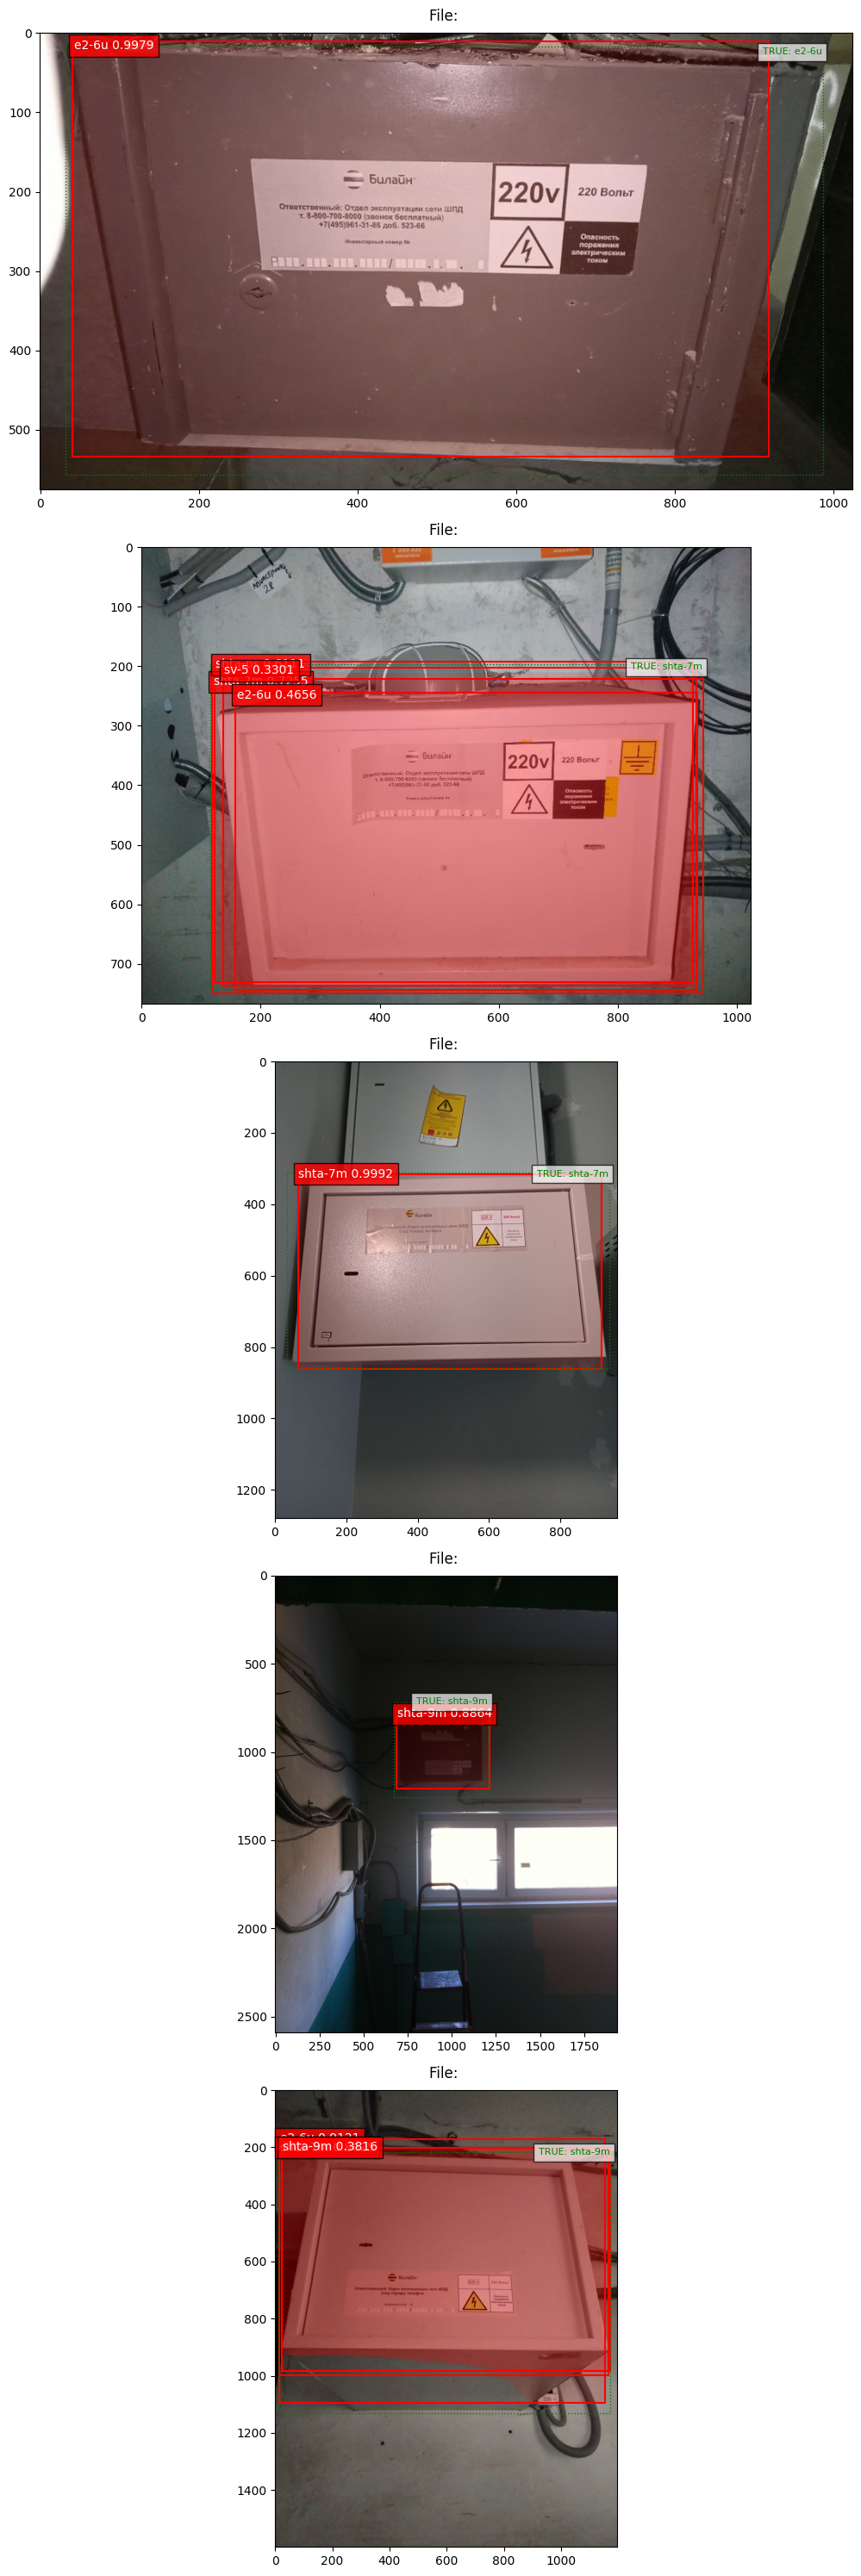

In [ ]:
# Визуализация предсказаний
visualize_predictions(model, val_dataset, num_samples=5)

## detection to df

In [ ]:
import pandas as pd
from tqdm import tqdm

# Конфигурация инференса
MODEL_PATH = '/kaggle/working/saved_models/best_model.pth'  # Путь к лучшей модели
# MODEL_PATH = '/content/saved_models/final_model.pth'  # Путь к лучшей модели
# MODEL_PATH = '/content/drive/MyDrive/object_detection_results/2025-06-24_06-46-55/saved_models/final_model.pth'  # Путь к лучшей модели
THRESHOLD = 0.5  # Порог уверенности для детекции
INFERENCE_DIR = DATA_DIR


In [ ]:
# Класс для инференса (только изображения без аннотаций)
class InferenceDataset(Dataset):
    def __init__(self, img_dir, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)

        return image, img_name

# Загрузка модели
def load_model_for_inference(model_path, num_classes, device):
    model = get_model(num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

In [ ]:
# Инициализация датасета и загрузчика
inference_dataset = InferenceDataset(
    img_dir=INFERENCE_DIR,
    transforms=transform
)
inference_loader = DataLoader(
    inference_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

# Загрузка модели
model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)

# Сбор предсказаний
results = []
with torch.no_grad():
    for images, image_names in tqdm(inference_loader, desc="Processing images"):
        images = [img.to(DEVICE) for img in images]
        predictions = model(images)

        for img_name, pred in zip(image_names, predictions):
            boxes = pred['boxes'].cpu().numpy()
            scores = pred['scores'].cpu().numpy()
            labels = pred['labels'].cpu().numpy()

            for i in range(len(boxes)):
                if scores[i] > THRESHOLD:
                    results.append({
                        'image_name': img_name,
                        'class_id': labels[i],
                        'class_name': CLASSES[labels[i]],
                        'xmin': boxes[i][0],
                        'ymin': boxes[i][1],
                        'xmax': boxes[i][2],
                        'ymax': boxes[i][3],
                        'confidence': scores[i]
                    })

# Создание DataFrame
df_results = pd.DataFrame(results)

# Сохранение результатов
os.makedirs('/kaggle/working/detection_results', exist_ok=True)
csv_path = '/kaggle/working/detection_results/detection_results.csv'
df_results.to_csv(csv_path, index=False)

print(f"Detection completed! Results saved to {csv_path}")
print(f"Total objects detected: {len(df_results)}")
print(f"Images processed: {len(inference_dataset)}")

Processing images: 100%|██████████| 935/935 [02:43<00:00,  5.70it/s]

Detection completed! Results saved to /kaggle/working/detection_results/detection_results.csv
Total objects detected: 1092
Images processed: 935


## F1 and val metrics

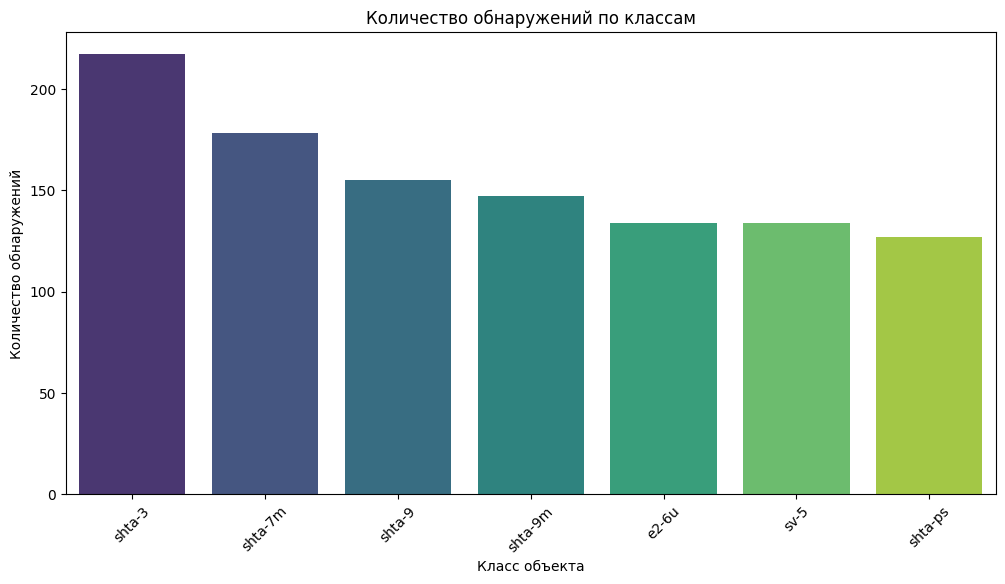


1. Количество обнаружений по классам:
class_name
shta-3     217
shta-7m    178
shta-9     155
shta-9m    147
e2-6u      134
sv-5       134
shta-ps    127
Name: count, dtype: int64


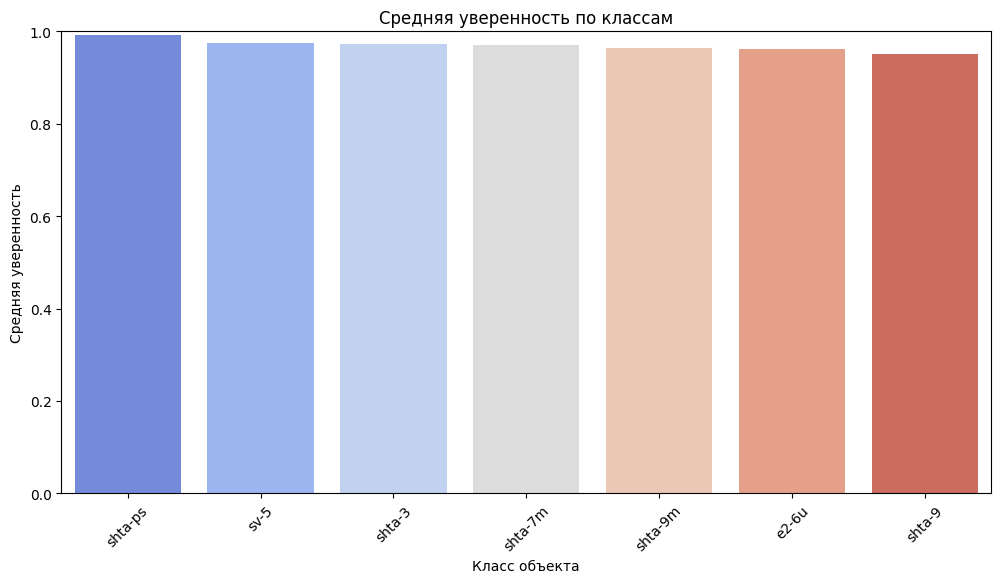


2. Средняя уверенность по классам:
class_name
shta-ps    0.991941
sv-5       0.973696
shta-3     0.971941
shta-7m    0.971225
shta-9m    0.964601
e2-6u      0.961530
shta-9     0.951878
Name: confidence, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


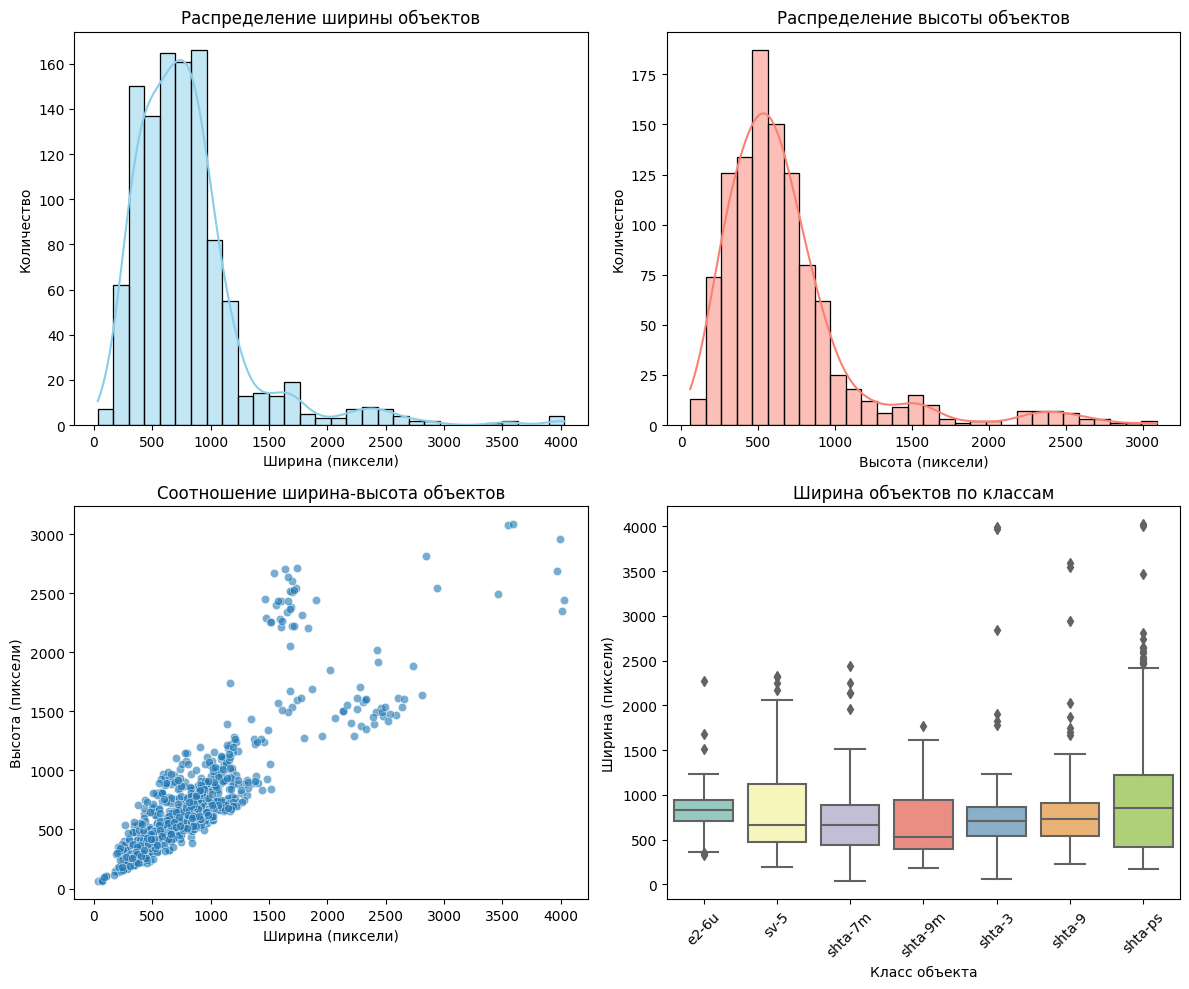


3. Статистика размеров объектов:
             width       height
count  1092.000000  1092.000000
mean    801.991031   677.016300
std     500.778485   457.124308
min      33.682210    59.736514
25%     483.957990   411.476290
50%     719.377625   572.666500
75%     933.221677   772.147277
max    4030.092060  3090.050327

4. Изображения без детекций: 2
Список сохранен в: /kaggle/working/detection_results/images_without_detections.csv

Анализ результатов детекции:
------------------------------------
1. Общее количество обнаруженных объектов: 1092
2. Количество обработанных изображений: 935
3. Изображений с детекциями: 933
4. Изображений без детекций: 2
5. Средняя уверенность по всем объектам: 0.9693
6. Минимальная уверенность: 0.5008
7. Максимальная уверенность: 0.9998

Распределение по классам:
class_name
shta-3     217
shta-7m    178
shta-9     155
shta-9m    147
e2-6u      134
sv-5       134
shta-ps    127

Средняя уверенность по классам:
class_name
shta-ps    0.991941
sv-5       0.9

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка результатов детекции
df = pd.read_csv('/kaggle/working/detection_results/detection_results.csv')

# 1. Количество обнаружений по классам
class_counts = df['class_name'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Количество обнаружений по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Количество обнаружений')
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/detection_results/class_counts.png')
plt.show()

print("\n1. Количество обнаружений по классам:")
print(class_counts)

# 2. Средняя уверенность по классам
confidence_by_class = df.groupby('class_name')['confidence'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')
plt.title('Средняя уверенность по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Средняя уверенность')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/detection_results/confidence_by_class.png')
plt.show()

print("\n2. Средняя уверенность по классам:")
print(confidence_by_class)

# 3. Распределение размеров объектов
# Вычисление ширины и высоты объектов
df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']

plt.figure(figsize=(12, 10))

# Распределение ширины
plt.subplot(2, 2, 1)
sns.histplot(df['width'], bins=30, kde=True, color='skyblue')
plt.title('Распределение ширины объектов')
plt.xlabel('Ширина (пиксели)')
plt.ylabel('Количество')

# Распределение высоты
plt.subplot(2, 2, 2)
sns.histplot(df['height'], bins=30, kde=True, color='salmon')
plt.title('Распределение высоты объектов')
plt.xlabel('Высота (пиксели)')
plt.ylabel('Количество')

# Соотношение ширина-высота
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='width', y='height', alpha=0.6)
plt.title('Соотношение ширина-высота объектов')
plt.xlabel('Ширина (пиксели)')
plt.ylabel('Высота (пиксели)')

# Размеры по классам
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='class_name', y='width', palette='Set3')
plt.title('Ширина объектов по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Ширина (пиксели)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/kaggle/working/detection_results/object_size_distribution.png')
plt.show()

print("\n3. Статистика размеров объектов:")
print(df[['width', 'height']].describe())

# 4. Изображения без детекций
# Получаем список всех обработанных изображений
all_images = set(inference_dataset.images)

# Получаем изображения с детекциями
detected_images = set(df['image_name'].unique())

# Находим изображения без детекций
no_detection_images = list(all_images - detected_images)

# Создаем отчет
no_detection_df = pd.DataFrame({
    'image_name': no_detection_images,
    'detection_status': 'No objects detected'
})

# Сохраняем в CSV
no_detection_path = '/kaggle/working/detection_results/images_without_detections.csv'
no_detection_df.to_csv(no_detection_path, index=False)

print(f"\n4. Изображения без детекций: {len(no_detection_images)}")
print(f"Список сохранен в: {no_detection_path}")

# Сохраняем полный отчет анализа
analysis_report = f"""
Анализ результатов детекции:
------------------------------------
1. Общее количество обнаруженных объектов: {len(df)}
2. Количество обработанных изображений: {len(all_images)}
3. Изображений с детекциями: {len(detected_images)}
4. Изображений без детекций: {len(no_detection_images)}
5. Средняя уверенность по всем объектам: {df['confidence'].mean():.4f}
6. Минимальная уверенность: {df['confidence'].min():.4f}
7. Максимальная уверенность: {df['confidence'].max():.4f}

Распределение по классам:
{class_counts.to_string()}

Средняя уверенность по классам:
{confidence_by_class.to_string()}
"""

with open('/kaggle/working/detection_results/analysis_report.txt', 'w') as f:
    f.write(analysis_report)

print(analysis_report)
print("Анализ завершен! Все результаты сохранены в /content/detection_results")

In [ ]:
from torchvision.ops import box_iou

def calculate_f1_per_class(model, data_loader, device, iou_threshold=0.5, conf_threshold=0.5):
    model.eval()

    # Инициализация счетчиков для каждого класса
    class_stats = {}
    for class_id in CLASSES.keys():
        if class_id == 0:  # Пропускаем фон
            continue
        class_stats[class_id] = {
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': 0
        }

    # Глобальные счетчики для итоговых метрик
    global_tp = 0
    global_fp = 0
    global_fn = 0

    with torch.no_grad():
        # Правильная обработка формата данных
        for images_list, targets_list in data_loader:  # Изменено здесь
            if images_list is None or len(images_list) == 0:
                continue

            # Перемещаем изображения на устройство
            images = [img.to(device) for img in images_list]  # Изменено здесь
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets_list)):  # Изменено здесь
                # Фильтрация предсказаний по порогу уверенности
                keep = output['scores'] > conf_threshold
                pred_boxes = output['boxes'][keep]
                pred_labels = output['labels'][keep]
                pred_scores = output['scores'][keep]

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                # Для каждого класса
                for class_id in class_stats.keys():
                    # Предсказания текущего класса
                    class_mask = pred_labels == class_id
                    pred_class_boxes = pred_boxes[class_mask]

                    # Истинные объекты текущего класса
                    gt_class_mask = gt_labels == class_id
                    gt_class_boxes = gt_boxes[gt_class_mask]

                    # Рассчет TP и FP
                    if len(pred_class_boxes) > 0:
                        if len(gt_class_boxes) > 0:
                            # Вычисление матрицы IoU
                            iou_matrix = box_iou(pred_class_boxes, gt_class_boxes)

                            # Сопоставление предсказаний с истинными объектами
                            matched_gt = set()
                            for pred_idx in range(len(pred_class_boxes)):
                                max_iou, gt_idx = iou_matrix[pred_idx].max(0)

                                if max_iou >= iou_threshold and gt_idx not in matched_gt:
                                    class_stats[class_id]['true_positives'] += 1
                                    global_tp += 1
                                    matched_gt.add(gt_idx)
                                else:
                                    class_stats[class_id]['false_positives'] += 1
                                    global_fp += 1

                            # Несопоставленные истинные объекты = FN
                            unmatched_gt = len(gt_class_boxes) - len(matched_gt)
                            class_stats[class_id]['false_negatives'] += unmatched_gt
                            global_fn += unmatched_gt
                        else:
                            # Все предсказания - ложные срабатывания (FP)
                            class_stats[class_id]['false_positives'] += len(pred_class_boxes)
                            global_fp += len(pred_class_boxes)
                    else:
                        # Все истинные объекты - пропущенные (FN)
                        if len(gt_class_boxes) > 0:
                            class_stats[class_id]['false_negatives'] += len(gt_class_boxes)
                            global_fn += len(gt_class_boxes)

    # Расчет метрик для каждого класса
    class_metrics = {}
    macro_f1 = 0
    macro_precision = 0
    macro_recall = 0
    total_support = 0
    total_weighted_f1 = 0
    total_weighted_precision = 0
    total_weighted_recall = 0

    for class_id, stats in class_stats.items():
        tp = stats['true_positives']
        fp = stats['false_positives']
        fn = stats['false_negatives']

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        support = tp + fn

        class_metrics[class_id] = {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'support': support
        }

        # Для макро-усреднения
        macro_f1 += f1
        macro_precision += precision
        macro_recall += recall

        # Для взвешенного усреднения
        total_support += support
        total_weighted_f1 += f1 * support
        total_weighted_precision += precision * support
        total_weighted_recall += recall * support

    # Расчет итоговых метрик
    num_classes = len(class_stats)
    macro_f1 /= num_classes if num_classes > 0 else 1
    macro_precision /= num_classes if num_classes > 0 else 1
    macro_recall /= num_classes if num_classes > 0 else 1

    weighted_f1 = total_weighted_f1 / (total_support + 1e-10)
    weighted_precision = total_weighted_precision / (total_support + 1e-10)
    weighted_recall = total_weighted_recall / (total_support + 1e-10)

    # Микро-усреднение (глобальные метрики)
    micro_precision = global_tp / (global_tp + global_fp + 1e-10)
    micro_recall = global_tp / (global_tp + global_fn + 1e-10)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-10)

    # Сводка по всем классам
    summary_metrics = {
        'micro': {
            'f1': micro_f1,
            'precision': micro_precision,
            'recall': micro_recall,
            'support': global_tp + global_fn
        },
        'macro': {
            'f1': macro_f1,
            'precision': macro_precision,
            'recall': macro_recall
        },
        'weighted': {
            'f1': weighted_f1,
            'precision': weighted_precision,
            'recall': weighted_recall
        },
        'total_tp': global_tp,
        'total_fp': global_fp,
        'total_fn': global_fn
    }

    return class_metrics, summary_metrics

In [ ]:
# Загрузка модели
model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)
model.to(DEVICE)

# Расчет метрик
class_metrics, summary_metrics = calculate_f1_per_class(model, test_loader, DEVICE)

# Вывод результатов по классам
print("\nДетальные метрики по классам:")
for class_id, metrics in class_metrics.items():
    class_name = CLASSES[class_id]
    print(f"{class_name} (ID: {class_id}):")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Support: {metrics['support']}")
    print()

# Вывод итоговых метрик
print("\nИтоговые метрики по всем классам:")
print(f"Общее количество объектов: {summary_metrics['micro']['support']}")
print(f"True Positives (TP): {summary_metrics['total_tp']}")
print(f"False Positives (FP): {summary_metrics['total_fp']}")
print(f"False Negatives (FN): {summary_metrics['total_fn']}")
print()

print("Микро-усреднение (глобальный подсчет):")
print(f"  F1-Score: {summary_metrics['micro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['micro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['micro']['recall']:.4f}")
print()

print("Макро-усреднение (среднее по классам):")
print(f"  F1-Score: {summary_metrics['macro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['macro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['macro']['recall']:.4f}")
print()

print("Взвешенное усреднение (по количеству объектов):")
print(f"  F1-Score: {summary_metrics['weighted']['f1']:.4f}")
print(f"  Precision: {summary_metrics['weighted']['precision']:.4f}")
print(f"  Recall: {summary_metrics['weighted']['recall']:.4f}")


Детальные метрики по классам:
shta-9m (ID: 1):
  F1-Score: 0.7931
  Precision: 0.7931
  Recall: 0.7931
  Support: 29

shta-ps (ID: 2):
  F1-Score: 0.9375
  Precision: 0.9375
  Recall: 0.9375
  Support: 16

shta-7m (ID: 3):
  F1-Score: 0.8485
  Precision: 0.7568
  Recall: 0.9655
  Support: 29

e2-6u (ID: 4):
  F1-Score: 0.8000
  Precision: 0.7368
  Recall: 0.8750
  Support: 16

shta-9 (ID: 5):
  F1-Score: 0.9231
  Precision: 1.0000
  Recall: 0.8571
  Support: 28

shta-3 (ID: 6):
  F1-Score: 0.7241
  Precision: 0.6000
  Recall: 0.9130
  Support: 23

sv-5 (ID: 7):
  F1-Score: 0.8333
  Precision: 0.7143
  Recall: 1.0000
  Support: 15


Итоговые метрики по всем классам:
Общее количество объектов: 156
True Positives (TP): 140
False Positives (FP): 41
False Negatives (FN): 16

Микро-усреднение (глобальный подсчет):
  F1-Score: 0.8309
  Precision: 0.7735
  Recall: 0.8974

Макро-усреднение (среднее по классам):
  F1-Score: 0.8371
  Precision: 0.7912
  Recall: 0.9059

Взвешенное усреднение (по 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches

def visualize_metrics(class_metrics, summary_metrics, classes_dict, save_dir="results"):
    """
    Визуализация метрик F1-Score, Precision и Recall

    Параметры:
    class_metrics (dict): Метрики по классам из calculate_f1_per_class
    summary_metrics (dict): Сводные метрики из calculate_f1_per_class
    classes_dict (dict): Словарь соответствия ID классов и их имен
    save_dir (str): Директория для сохранения графиков
    """
    # Создаем директорию для сохранения, если её нет
    os.makedirs(save_dir, exist_ok=True)

    # Создаем DataFrame для отчета по классам
    class_data = []
    # Handle "unknown" class if it exists and has 0 support
    filtered_class_metrics = {k: v for k, v in class_metrics.items() if v['support'] > 0 or classes_dict[k] != 'unknown'}

    for class_id, metrics in filtered_class_metrics.items():
        class_name = classes_dict[class_id]
        class_data.append({
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Support': metrics['support']
        })


    df_class_report = pd.DataFrame(class_data)

    # Ensure the DataFrame is not empty before plotting
    if df_class_report.empty:
        print("No classes with support > 0 found for visualization.")
        return {}


    # График F1-Score по классам
    plt.figure(figsize=(12, 6))
    plt.bar(df_class_report['Class'], df_class_report['F1-Score'], color='skyblue')
    plt.axhline(y=summary_metrics['macro']['f1'], color='r', linestyle='--',
                label=f'Macro F1-Score: {summary_metrics["macro"]["f1"]:.4f}')
    plt.title('F1-Score по классам')
    plt.xlabel('Класс')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    f1_by_class_path = os.path.join(save_dir, 'f1_by_class.png')
    plt.savefig(f1_by_class_path)
    plt.show()
    plt.close()

    # Тепловая карта метрик
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_class_report[['Precision', 'Recall', 'F1-Score']],
                annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=df_class_report['Class'])
    plt.title('Метрики по классам')
    plt.tight_layout()
    heatmap_path = os.path.join(save_dir, 'metrics_heatmap.png')
    plt.savefig(heatmap_path)
    plt.show()
    plt.close()

    # График Precision-Recall по классам
    plt.figure(figsize=(10, 8))

    # Определяем динамические границы
    min_precision = df_class_report['Precision'].min()
    min_recall = df_class_report['Recall'].min()
    max_precision = df_class_report['Precision'].max()
    max_recall = df_class_report['Recall'].max()

    # Рассчитываем буфер
    buffer = 0.05
    x_min = max(0.0, min_recall - buffer)
    x_max = min(1.0, max_recall + buffer)
    y_min = max(0.0, min_precision - buffer)
    y_max = min(1.0, max_precision + buffer)

    # Ensure at least a small range to avoid errors
    x_min = min(x_min, x_max - 0.01)
    y_min = min(y_min, y_max - 0.01)


    # Создаем scatter plot
    for _, row in df_class_report.iterrows():
        plt.scatter(row['Recall'], row['Precision'], s=120, edgecolors='black')
        plt.text(
            row['Recall'],
            row['Precision'] + 0.005,
            f"{row['Class']}\nF1={row['F1-Score']:.4f}",
            fontsize=9,
            ha='center',
            va='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

    # Настройка осей и сетки
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall по классам')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Добавляем диагональ
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.2) # Draw from (0,0) to (1,1)

    # Добавляем изолинии F1-Score
    for f1 in [0.5, 0.7, 0.9]:
        # Generate points for the isoline within the plot limits
        x_iso = np.linspace(x_min, x_max, 100)
        with np.errstate(divide='ignore', invalid='ignore'):
            y_iso = np.where(
                (2 * x_iso - f1) != 0,
                f1 * x_iso / (2 * x_iso - f1),
                np.nan
            )

        # Filter out points outside the plot limits and invalid values
        valid_points = (~np.isnan(y_iso)) & (y_iso >= y_min) & (y_iso <= y_max)

        # Find segments of valid points
        if np.any(valid_points):
            valid_indices = np.where(valid_points)[0]
            # Find contiguous segments by looking for breaks in consecutive indices
            breaks = np.where(np.diff(valid_indices) != 1)[0]
            segments = np.split(valid_indices, breaks + 1)

            for segment_indices in segments:
                if len(segment_indices) > 1: # Need at least 2 points to draw a line
                    plt.plot(x_iso[segment_indices], y_iso[segment_indices], 'r--', alpha=0.3, linewidth=0.8)

            # Add label to the last segment's end point if available
            if segments and len(segments[-1]) > 0:
                last_idx_in_segment = segments[-1][-1]
                plt.text(x_iso[last_idx_in_segment], y_iso[last_idx_in_segment], f"F1={f1}",
                         color='red', fontsize=8, ha='right', va='bottom')


    plt.tight_layout()
    pr_path = os.path.join(save_dir, 'precision_recall.png')
    plt.savefig(pr_path)
    plt.show()
    plt.close()

    # Дополнительный график: сравнение микро, макро и взвешенных метрик
    metrics_types = ['micro', 'macro', 'weighted']
    metric_names = ['f1', 'precision', 'recall']

    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(metrics_types))

    for i, metric in enumerate(metric_names):
        values = [summary_metrics[m_type][metric] for m_type in metrics_types]
        plt.bar(index + i * bar_width, values, bar_width, label=metric.capitalize())

    plt.xlabel('Тип усреднения')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение микро, макро и взвешенных метрик')
    plt.xticks(index + bar_width/2, [t.capitalize() for t in metrics_types])
    plt.ylim(0, 1.05) # Adjusted y-limit
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    summary_path = os.path.join(save_dir, 'summary_metrics.png')
    plt.savefig(summary_path)
    plt.show()
    plt.close()

    # Сохраняем данные в CSV
    csv_path = os.path.join(save_dir, 'metrics_report.csv')
    df_class_report.to_csv(csv_path, index=False)

    # Добавляем сводные метрики в отдельный CSV
    summary_data = []
    for m_type in metrics_types:
        for metric in metric_names:
            summary_data.append({
                'Type': m_type,
                'Metric': metric,
                'Value': summary_metrics[m_type][metric]
            })

    summary_df = pd.DataFrame(summary_data)
    summary_csv_path = os.path.join(save_dir, 'summary_metrics.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    return {
        'f1_by_class': f1_by_class_path,
        'metrics_heatmap': heatmap_path,
        'precision_recall': pr_path,
        'summary_metrics': summary_path,
        'class_report_csv': csv_path,
        'summary_report_csv': summary_csv_path
    }

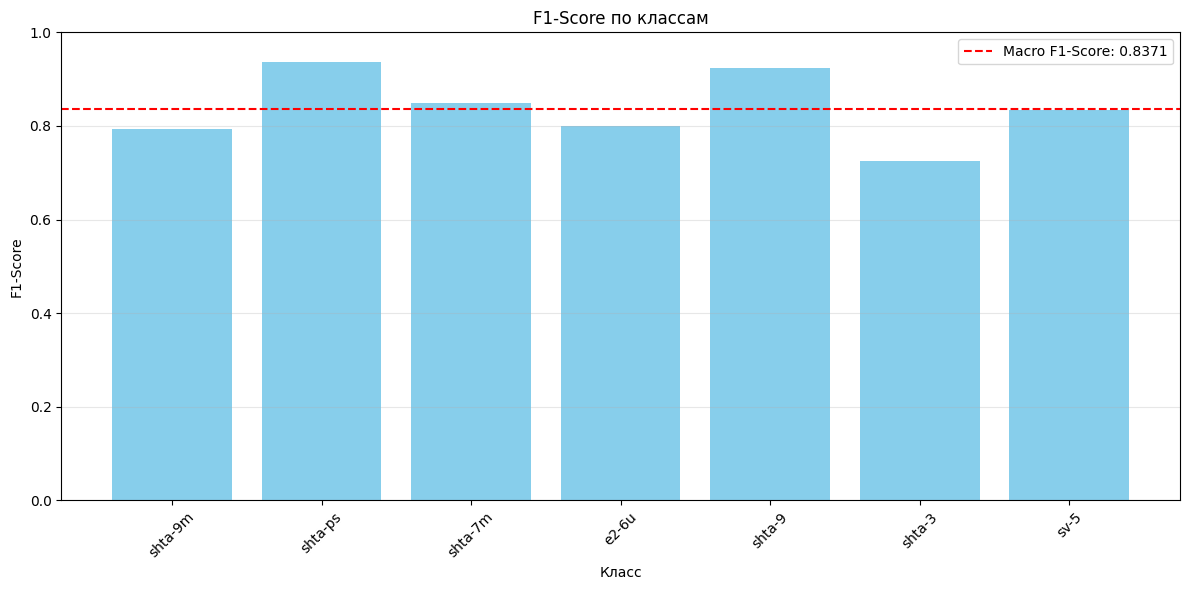

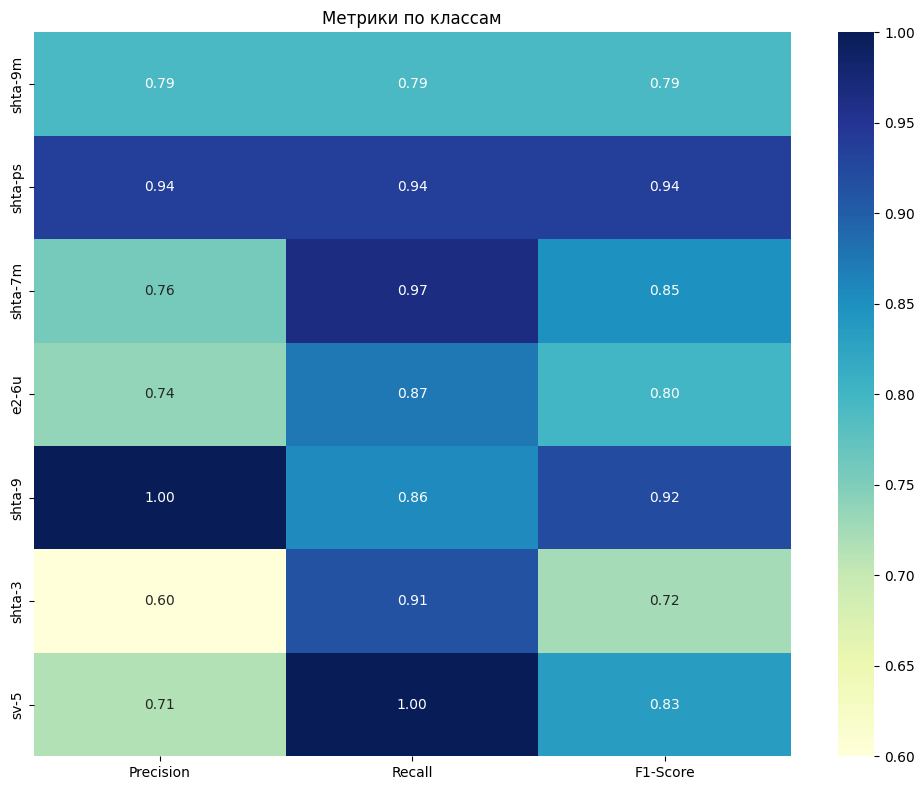

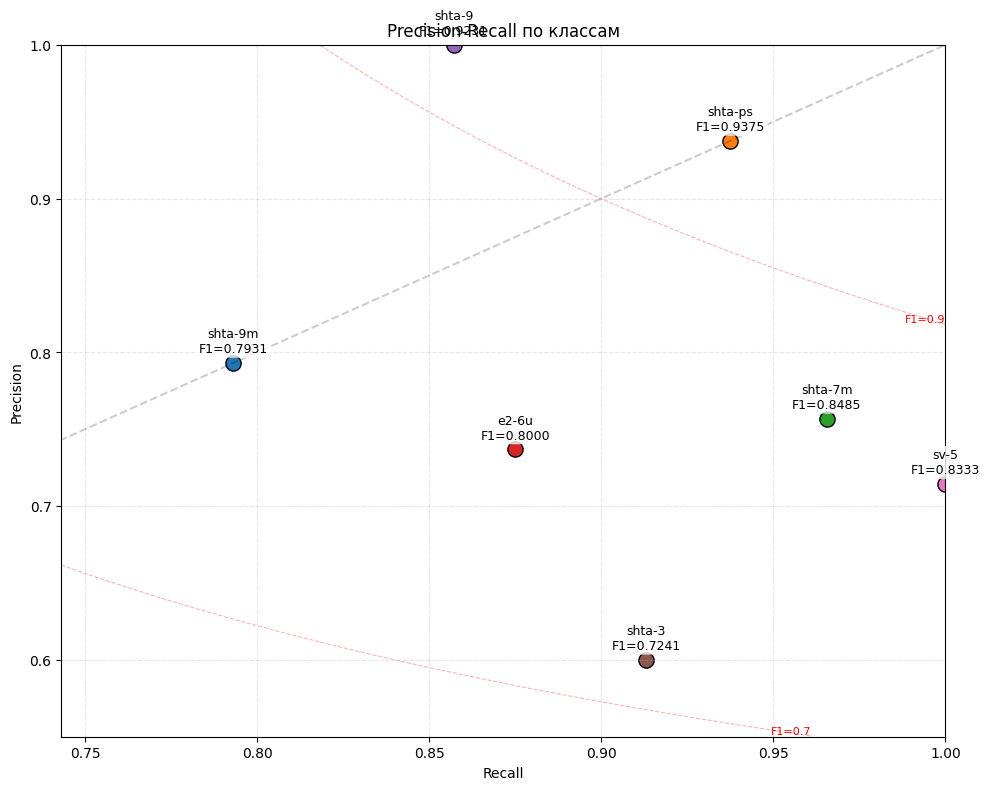

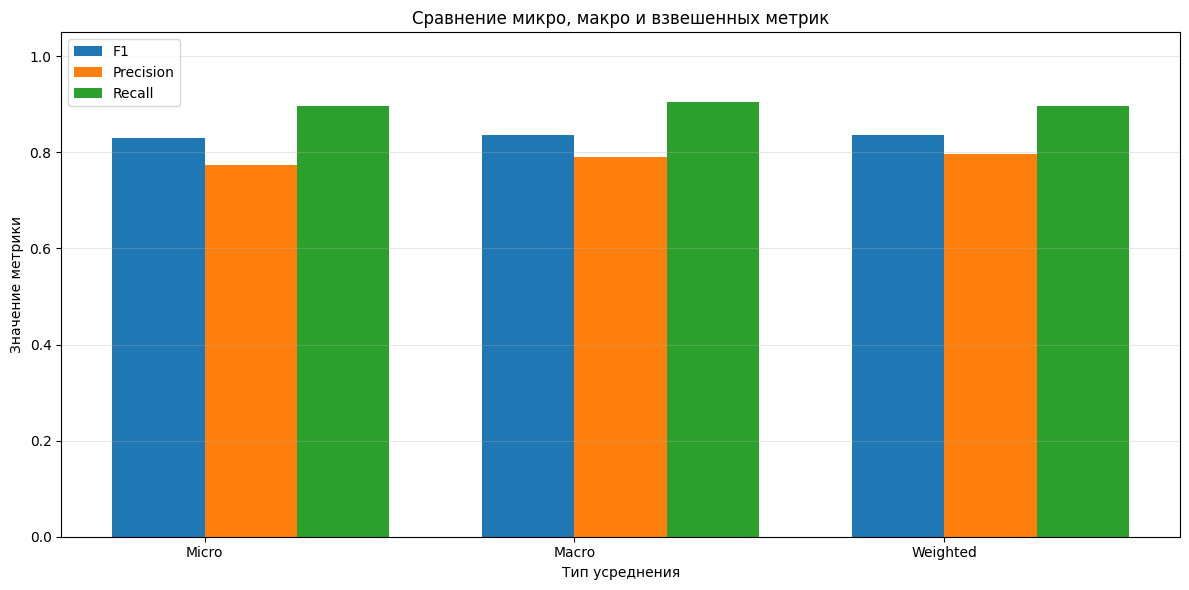

In [ ]:
# Визуализация
visualization_paths = visualize_metrics(
    class_metrics=class_metrics,
    summary_metrics=summary_metrics,
    classes_dict=CLASSES,  # Ваш словарь классов {id: name}
    save_dir="metrics_results"
)